In [1]:
# Check which GPU is assigned
!nvidia-smi

# Or within TensorFlow
import tensorflow as tf
print(tf.test.gpu_device_name())


Sat Oct 18 11:04:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install tensorflow.keras

In [6]:


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [9]:
# Example: unzip it into the /content/data directory
!unzip -q "/content/drive/MyDrive/archive.zip" -d "/content/data"


In [11]:
!pip install split-folders
import splitfolders


In [12]:
input_folder = "/content/data/Fruits_1/Training"   # where your current class folders are
output_folder = "/content/data/Fruits_1_split"     # new folder for split data


In [13]:
# 80% train, 20% test (no validation)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.2))


Copying files: 2677 files [00:00, 9574.26 files/s]


In [14]:
train_dir = '/content/data/Fruits_1_split/train'
test_dir = '/content/data/Fruits_1_split/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)


Found 2140 images belonging to 6 classes.
Found 537 images belonging to 6 classes.


In [17]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax') # Changed from 5 to 6
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,550 (6.61 MB)

 Trainable params: 1,732,550 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=test_gen
    )


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4959 - loss: 1.2298

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.4995 - loss: 1.2216 - val_accuracy: 0.9497 - val_loss: 0.1280
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9722 - loss: 0.0874 - val_accuracy: 0.9870 - val_loss: 0.0336
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9860 - loss: 0.0375 - val_accuracy: 0.9944 - val_loss: 0.0275
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9780 - loss: 0.0649 - val_accuracy: 1.0000 - val_loss: 8.2585e-05
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9975 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.2295e-05
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 1.000

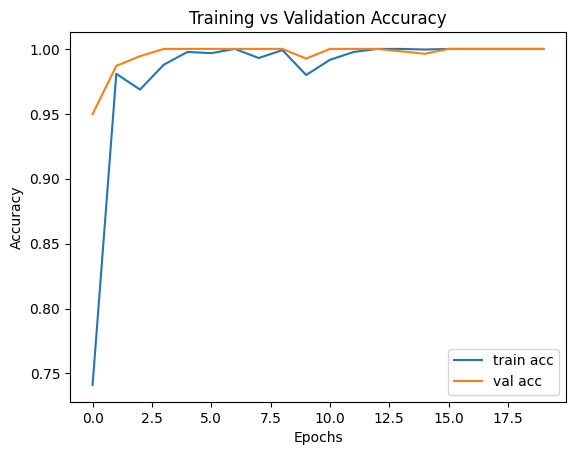

In [19]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(), plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()


In [20]:
model.save('/content/drive/MyDrive/fruit_classifier_cnn.h5')


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [22]:
# Get ground truth labels and filenames from test generator
test_gen.reset()
Y_true = test_gen.classes
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())

# Predict class probabilities using model
Y_pred_probs = model.predict(test_gen)

# Convert predicted probabilities to class labels
Y_pred = np.argmax(Y_pred_probs, axis=1)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [23]:
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

       Pineapple       0.12      0.12      0.12        74
  Pineapple Mini       0.12      0.12      0.12        90
       Raspberry       0.11      0.11      0.11        84
      Redcurrant       0.24      0.24      0.24        99
      Strawberry       0.19      0.19      0.19        90
Strawberry Wedge       0.19      0.19      0.19       100

        accuracy                           0.17       537
       macro avg       0.16      0.16      0.16       537
    weighted avg       0.17      0.17      0.17       537

